In [13]:
import pandas as pd
import statsmodels.graphics.tsaplots as sgt 
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import zipfile
import requests
import io
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
FILE_NAME_CSV_DATASET_CLIMA = 'https://raw.githubusercontent.com/PabloSGomez50/humai-solar-panels/main/scraper_clima/clima_sydney_limpio3.csv'
FILE_NAME_CSV_DATASET_PRODUCCION = 'https://github.com/PabloSGomez50/humai-solar-panels/blob/main/dataset_produccion_energia/produccion.csv.zip?raw=true'

In [3]:
def get_dataset_clima():
    df_clima = pd.read_csv(FILE_NAME_CSV_DATASET_CLIMA)
    df_clima.drop(columns=['Unnamed: 0'], inplace = True)
    df_clima.rename(columns={'Date': 'Datetime'}, inplace = True)    
    
    # elimino dos registros que estaban duplicados
    dupli_1_index = df_clima[(df_clima.Datetime == '2013-04-07 02:00:00') & (df_clima.Barometer == 1023)].index
    dupli_2_index = df_clima[(df_clima.Datetime == '2013-04-07 02:30:00') & (df_clima.Barometer == 1023)].index
    df_clima = df_clima.drop(df_clima.index[dupli_1_index]).drop(df_clima.index[dupli_2_index]) 

    df_clima['Datetime'] = pd.to_datetime(df_clima['Datetime'], format='%Y-%m-%d %H:%M:%S')
    df_clima['Hour'] = df_clima.Datetime.dt.hour    
    df_clima['Hour'] = df_clima['Hour'].astype(int)
    df_clima['Month'] = df_clima.Datetime.dt.month
    df_clima['Month'] = df_clima['Month'].astype(int)
    df_clima['Month_name'] = df_clima['Datetime'].dt.month_name().apply(lambda x: x)

    return df_clima

def get_dataset_produccion():
    content = requests.get(FILE_NAME_CSV_DATASET_PRODUCCION).content
    zip_file = zipfile.ZipFile(io.BytesIO(content))
    file = zip_file.open("produccion.csv")
    df_produccion = pd.read_csv(file)
    df_produccion.rename(columns={'datetime': 'Datetime'}, inplace = True)
    df_produccion['Datetime'] = pd.to_datetime(df_produccion['Datetime'], format='%Y-%m-%d %H:%M:%S')

    return df_produccion

def join_dataset(df_clima, df_produccion, customer_id):

    # me quedo con un unico customer_id
    df_produccion_only_one_customer = df_produccion[df_produccion.Customer == customer_id]
    df_produccion_only_one_customer.drop(columns='Customer', inplace = True)

    # luego de este join van a aparecer muchos registros con los datos del clima en NaN
    df_join = df_produccion_only_one_customer.merge(df_clima, left_on="Datetime", right_on="Datetime", how="left")

    # casteo la fecha para que sea datatime
    df_join['Datetime'] = pd.to_datetime(df_join['Datetime'], format='%Y-%m-%d %H:%M:%S')

    # Ordeno el dataset para que la imputacion por el valor anterior funcione correctamente
    df_join.sort_values(by ='Datetime', inplace=True)
    df_join.fillna(method = 'ffill', inplace = True)

    # Seteo la fecha como index y establezco la frecuencia    
    df_join.set_index("Datetime", inplace=True)
    df_join = df_join.asfreq('30T')
    
    return df_join

In [4]:
df_clima = get_dataset_clima()

In [5]:
df_produccion = get_dataset_produccion()

# Analisis del dataset

Como primer paso doy un vistazo rapido de los datos

In [6]:
Customer_id = 1
df_join = join_dataset(df_clima, df_produccion, Customer_id)
df_join

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,Produccion,Temp,Weather,Wind,Humidity,Barometer,Visibility,Clear,Partly sunny,Passing clouds,Scattered clouds,Sunny,Hour,Month,Month_name
Datetime,,,,,,,,,,,,,,,
2012-07-01 00:00:00,0.0,12.0,Clear,11.0,54.0,1014.0,16.0,1.0,0.0,0.0,0.0,0.0,0.0,7.0,July
2012-07-01 00:30:00,0.0,12.0,Clear,11.0,54.0,1014.0,16.0,1.0,0.0,0.0,0.0,0.0,0.0,7.0,July
2012-07-01 01:00:00,0.0,12.0,Clear,9.0,54.0,1014.0,16.0,1.0,0.0,0.0,0.0,0.0,1.0,7.0,July
2012-07-01 01:30:00,0.0,12.0,Clear,9.0,54.0,1014.0,16.0,1.0,0.0,0.0,0.0,0.0,1.0,7.0,July
2012-07-01 02:00:00,0.0,12.0,Clear,7.0,54.0,1014.0,16.0,1.0,0.0,0.0,0.0,0.0,2.0,7.0,July
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-06-30 21:30:00,0.0,12.0,Passing clouds,15.0,94.0,1024.0,8.0,0.0,0.0,1.0,0.0,0.0,21.0,6.0,June
2013-06-30 22:00:00,0.0,12.0,Passing clouds,17.0,88.0,1024.0,8.0,0.0,0.0,1.0,0.0,0.0,22.0,6.0,June
2013-06-30 22:30:00,0.0,13.0,Passing clouds,11.0,82.0,1024.0,8.0,0.0,0.0,1.0,0.0,0.0,22.0,6.0,June


## Analisis de la estacionalidad

Analizar la estacionalidad de una serie temporal significa examinar los patrones repetitivos en la frecuencia de los datos en un período de tiempo específico, como días, meses o años. Esto puede incluir la identificación de tendencias y ciclos regulares, así como la detección de eventos puntuales, como picos o caídas en los datos.

A simple vista lo primero que se ve es que la serie esta formada por un monton de barras altas y bajas alternadamente, y que durante el verano de sidney es mas elevada la produccion y mas baja en invierno, lo cual tiene sentido.

AxesSubplot(0.125,0.125;0.775x0.755)


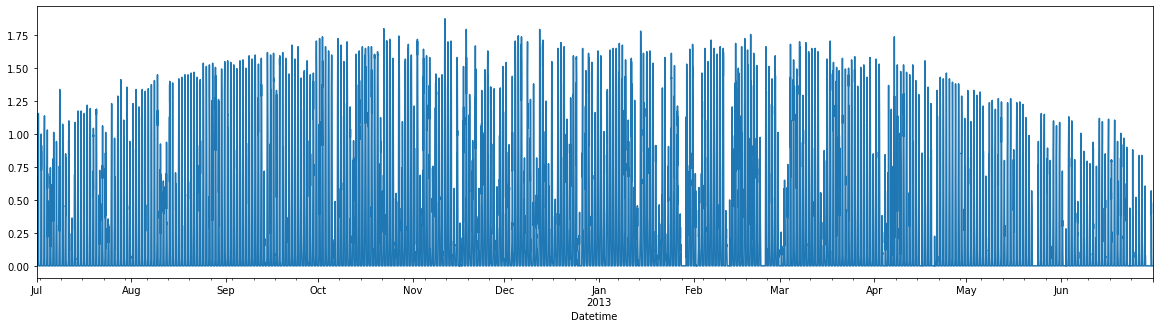

In [19]:
# grafico toda la serie completa
df_join.Produccion.plot(figsize = (20,5))


Haciendo lupa en un mes concreto se ve con muchisima mas claridad la perioricidad diaria de la serie.

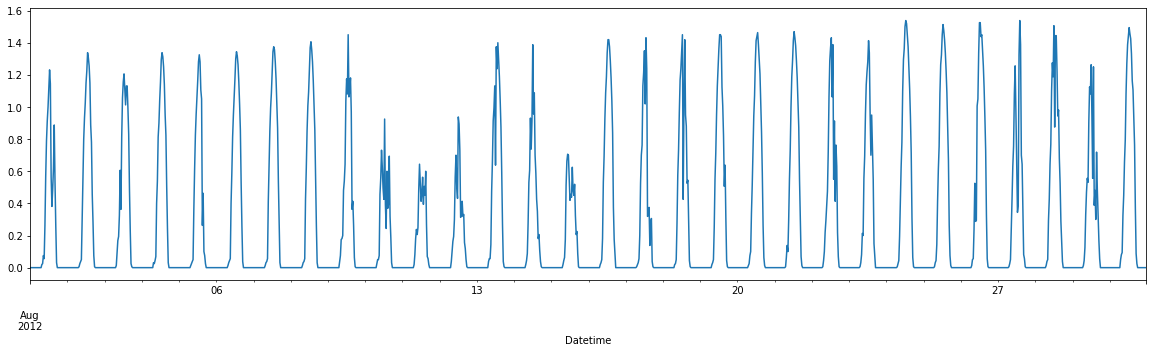

In [8]:
df_join.loc['2012-08-01 00:00:00':'2012-08-30 23:30:00'].Produccion.plot(figsize = (20,5))


Si vemos un dia en concreto se ve claramente que durante la noche no se genera energia y que en la medida de que el dia transcurre la produccion aumenta y decae nuevamente hacia la noche

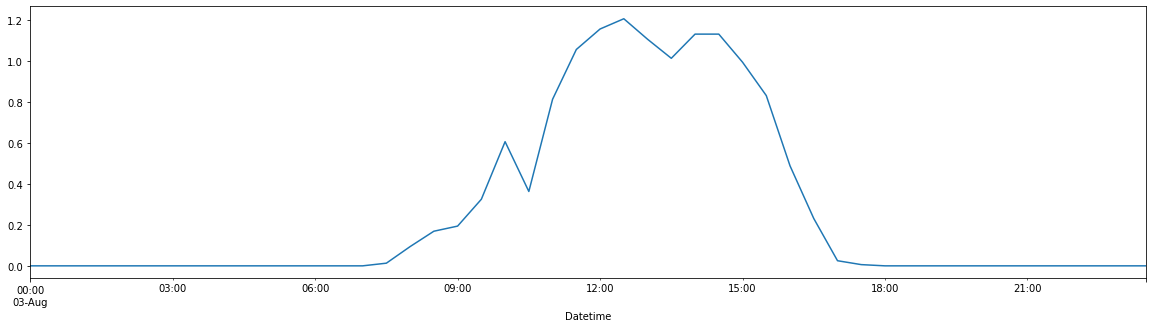

In [21]:
df_join.loc['2012-08-03 00:00:00':'2012-08-03 23:30:00'].Produccion.plot(figsize = (20,5))


In [9]:
prod_promedio_por_hora = df_join.groupby('Hour').aggregate({'Produccion': 'mean'})
prod_promedio_por_mes = df_join.groupby('Month').aggregate({'Produccion': 'mean'})
prod_promedio_por_nomnbre_mes = df_join.groupby('Month_name').aggregate({'Produccion': 'mean'})
prod_promedio_por_clima = df_join.groupby('Weather').aggregate({'Produccion': 'mean'})

## Analisis por Horas

En este grafico en donde promedio la cantidad de energia generada por hora, vuelvo a confirmar que durante la noche no se genera energia y que gradualmente la energia generada crece con un pico hacia las 13 y luego va decreciendo lentamente hasta dejar de producir en la noche, la curva tiene forma normal

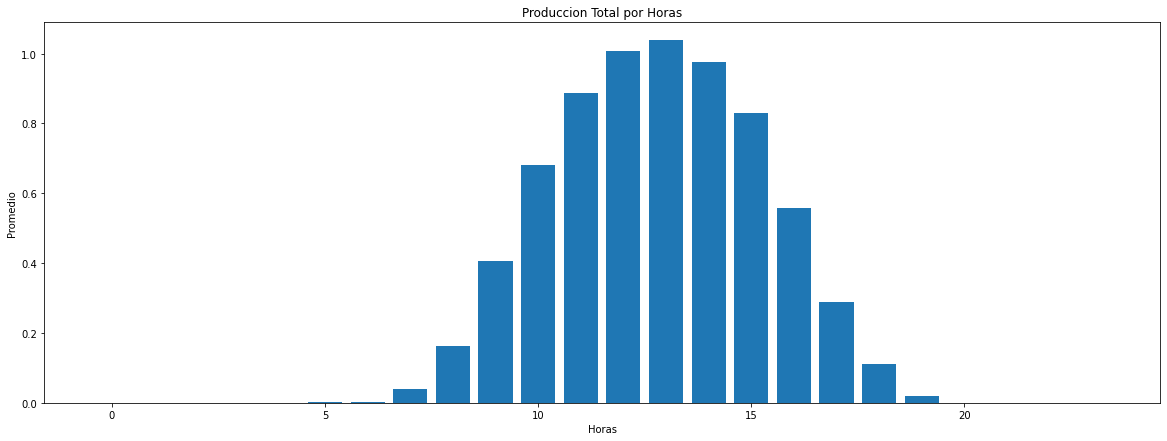

In [11]:
# Crear el gráfico de barras
plt.figure(figsize=(20, 7))
plt.bar(prod_promedio_por_hora.index, prod_promedio_por_hora['Produccion'])

# Añadir etiquetas y títulos
plt.xlabel('Horas')
plt.ylabel('Promedio')
plt.title('Produccion Total por Horas')

# Mostrar el gráfico
plt.show()


En este grafico de cajas veo lo mismo pero apreciando ademas la distribucion de la produccion energetica hora por hora.

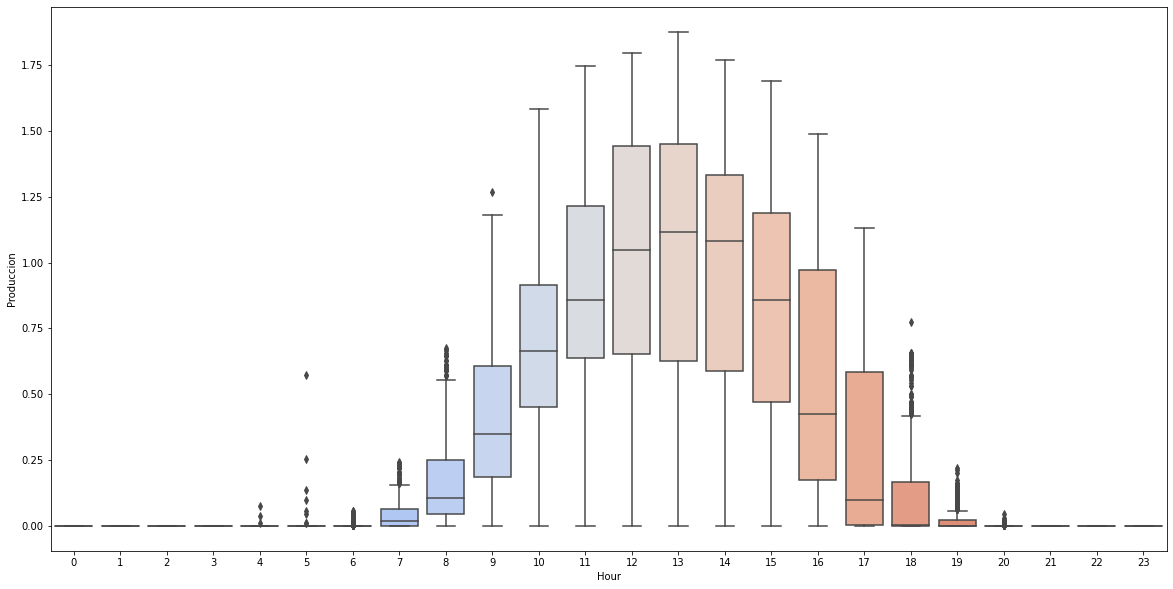

In [14]:
plt.figure(figsize=(20, 10))
sns.boxplot(x='Hour', y='Produccion', data=df_join, palette='coolwarm')
plt.xticks(np.arange(24), range(24))
plt.show()


Repito el mismo analisis para los meses y confirmo de manera visual que en invierno se produce menos energia y que en verano la produccion es maxima.

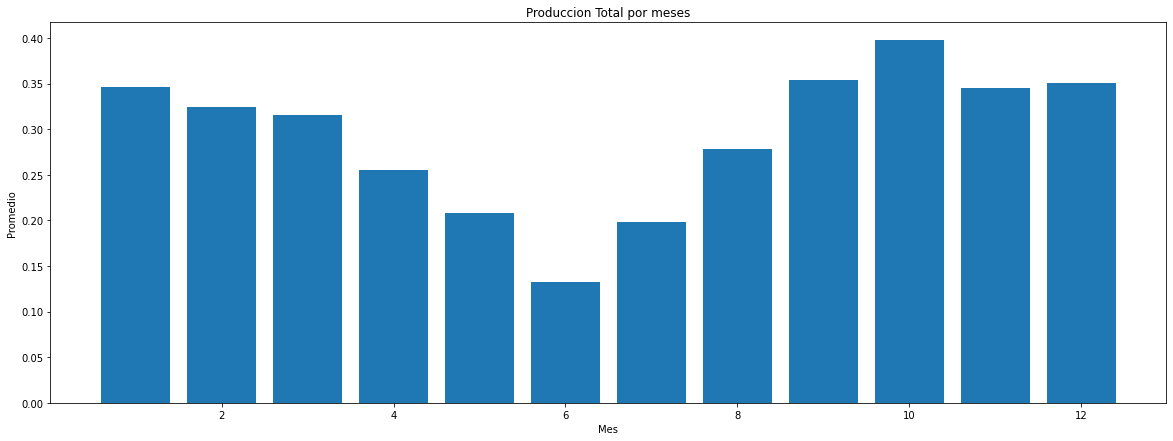

In [15]:
# Crear el gráfico de barras
plt.figure(figsize=(20, 7))
plt.bar(prod_promedio_por_mes.index, prod_promedio_por_mes['Produccion'])

# Añadir etiquetas y títulos
plt.xlabel('Mes')
plt.ylabel('Promedio')
plt.title('Produccion Total por meses')

# Mostrar el gráfico
plt.show()


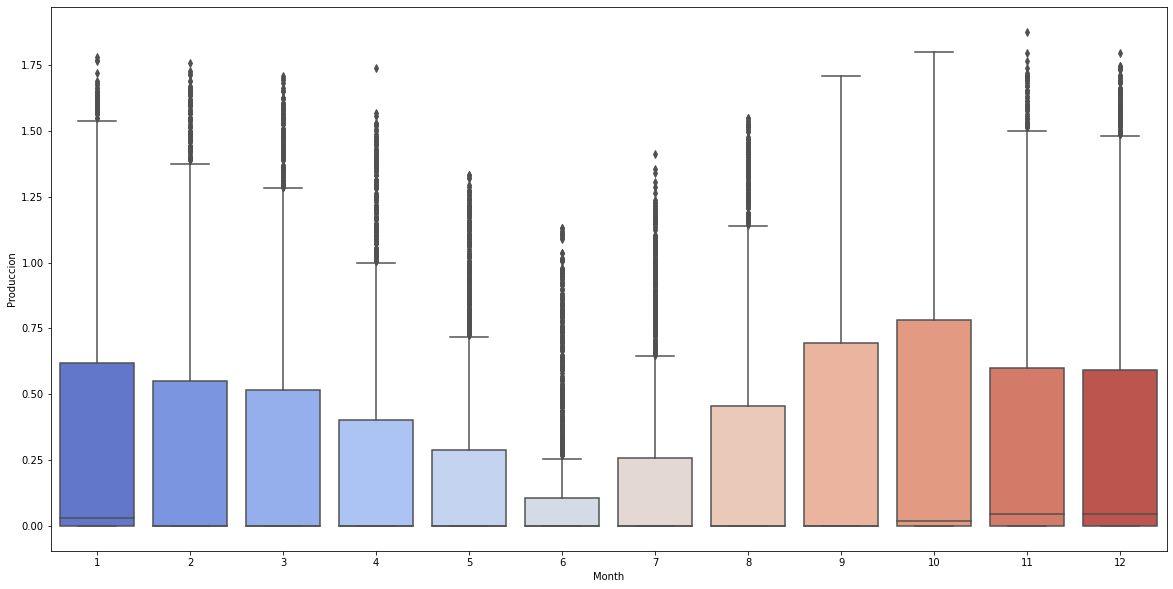

In [16]:
plt.figure(figsize=(20, 10))
sns.boxplot(x='Month', y='Produccion', data=df_join, palette='coolwarm')
plt.xticks(np.arange(12) , range(1, 13))
plt.show()

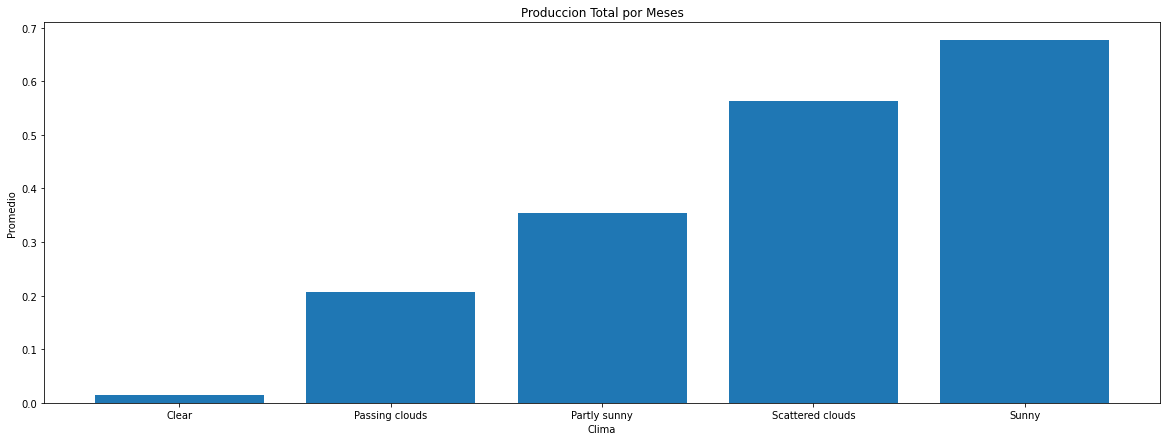

In [24]:
# Crear el gráfico de barras
plt.figure(figsize=(20, 7))
prod_promedio_por_clima = prod_promedio_por_clima.sort_values(by='Produccion')
plt.bar(prod_promedio_por_clima.index, prod_promedio_por_clima['Produccion'])

# Añadir etiquetas y títulos
plt.xlabel('Clima')
plt.ylabel('Promedio')
plt.title('Produccion Total por Meses')

# Mostrar el gráfico
plt.show()

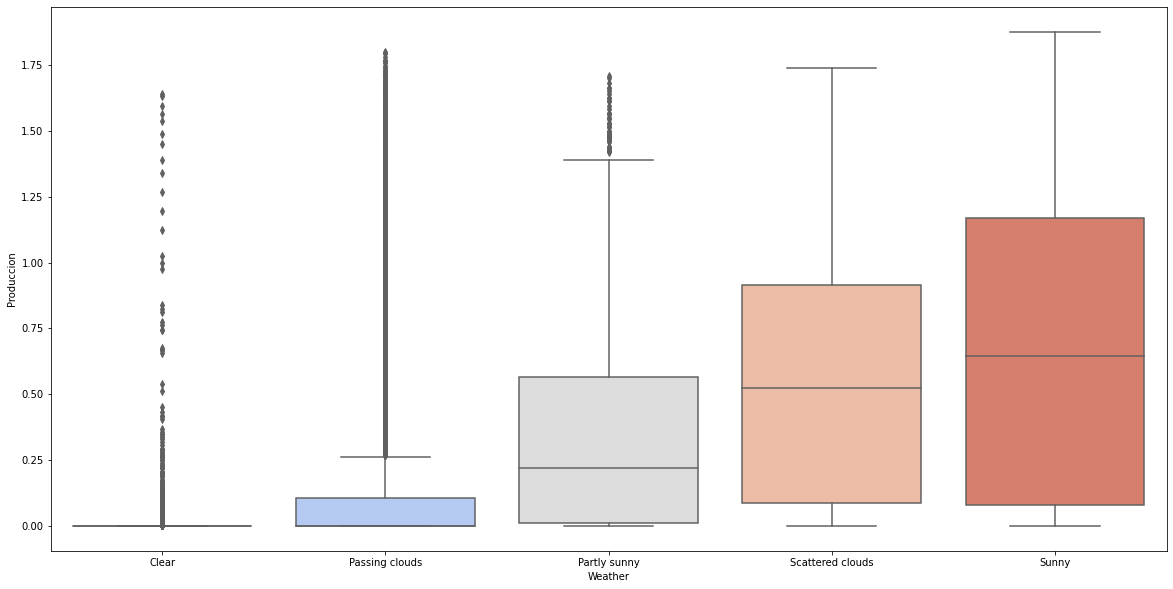

In [37]:
order = ['Clear', 'Passing clouds', 'Partly sunny', 'Scattered clouds', 'Sunny']

plt.figure(figsize=(20, 10))
sns.boxplot(x='Weather', y='Produccion', data=df_join, palette='coolwarm', order=order)
plt.show()

El resultado del test ADF sugiere que la serie temporal es estacionaria.

El valor de la estadística ADF es -9.19, que es mucho menor que los valores críticos en el 1%, 5% y 10% de los niveles de significancia. Esto significa que podemos rechazar la hipótesis nula de que la serie temporal no es estacionaria con una confianza del 99%, 95% y 90%, respectivamente.

El valor de p-value es de 2.19e-15, que es extremadamente pequeño y mucho menor que el nivel de significancia del 5%. Esto significa que la hipótesis nula de no-estacionariedad es rechazada con una confianza del 95%.

Por lo tanto, podemos concluir que la serie temporal es estacionaria.

In [ ]:
result = adfuller(df_join.Produccion)

print("ADF: ", result[0])
print("p-value: ", result[1])
print("nobs: ", result[2])
print("critical values: ", result[4])
print("usedlag: ", result[3])

ADF:  -9.185665718821259
p-value:  2.191164128519894e-15
nobs:  44
critical values:  {'1%': -3.4307242638530675, '5%': -2.861705410152796, '10%': -2.5668580435332715}
usedlag:  17475


<Figure size 1440x720 with 0 Axes>

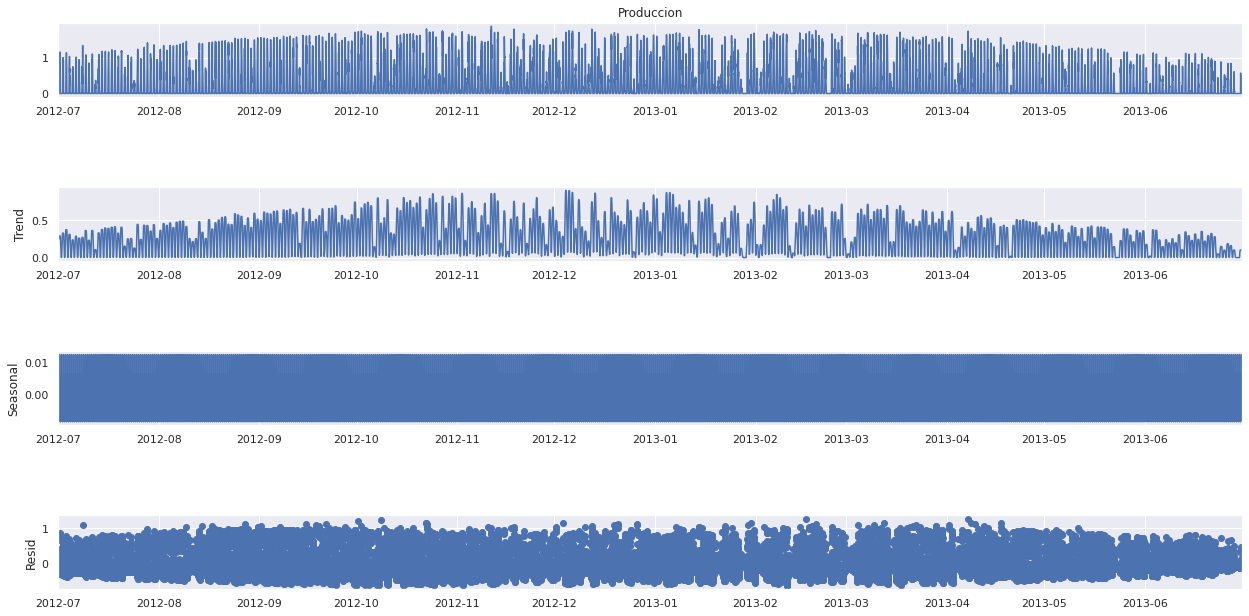

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

s_dec_additive = seasonal_decompose(df_join.Produccion, model="additive", period=30)

plt.figure(figsize=(20, 10))
s_dec_additive.plot()
plt.gcf().set_size_inches(20, 10)
plt.show()





In [ ]:
s_dec_multiplicative = seasonal_decompose(df_join.Produccion, model="multiplicative", period=30)

plt.figure(figsize=(20, 10))
s_dec_multiplicative.plot()
plt.gcf().set_size_inches(20, 10)
plt.show()

ValueError: ignored

<Figure size 1440x720 with 0 Axes>

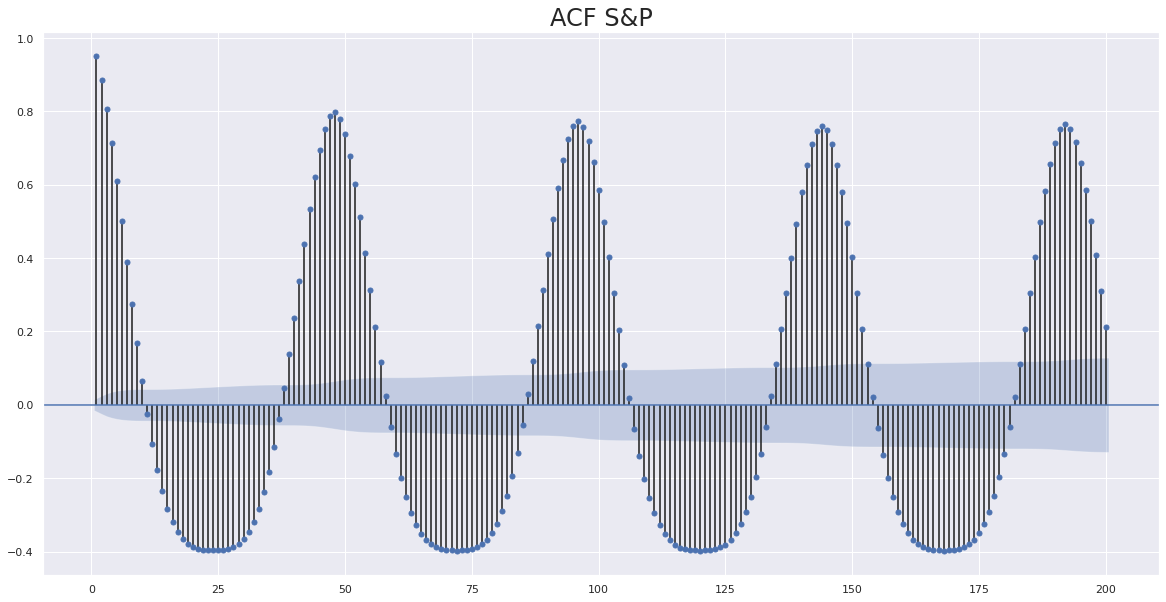

In [ ]:
plt.figure(figsize=(20,10))
sgt.plot_acf(df_join.Produccion, lags = 200, zero = False)
plt.title("ACF S&P", size = 24)
plt.gcf().set_size_inches(20, 10)
plt.show()


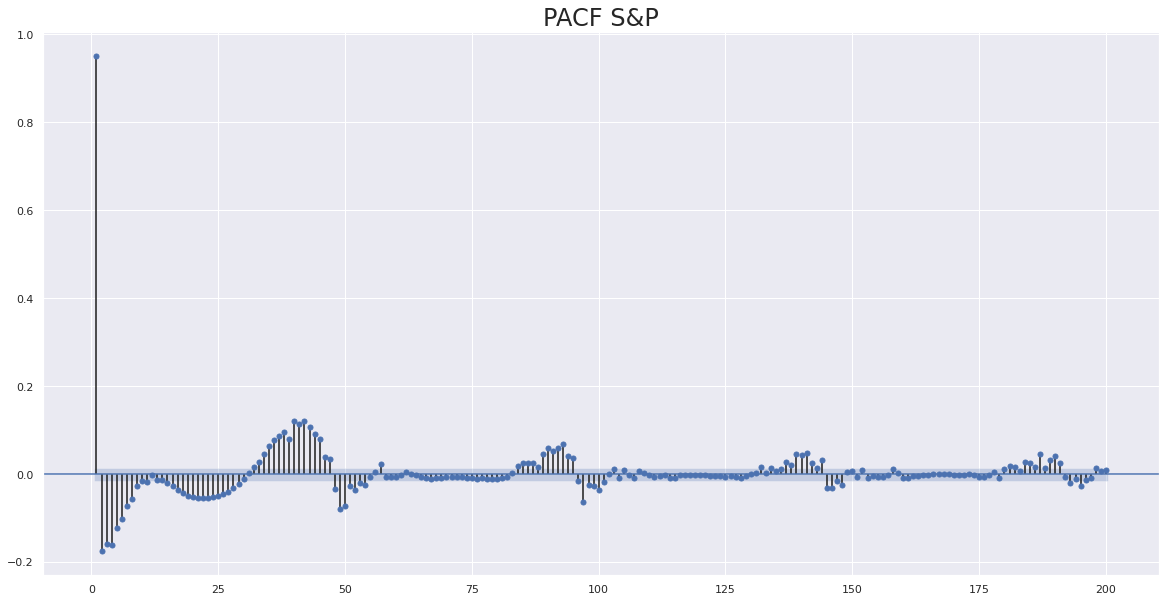

In [ ]:
sgt.plot_pacf(df_join.Produccion, lags = 200, zero = False, method = ('ols'))
plt.title("PACF S&P", size = 24)
plt.gcf().set_size_inches(20, 10)

plt.show()

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


(-11.005426652746598,
 6.522410105612038e-20,
 44,
 17475,
 {'1%': -3.4307242638530675,
  '5%': -2.861705410152796,
  '10%': -2.5668580435332715},
 -35640.47959805631)

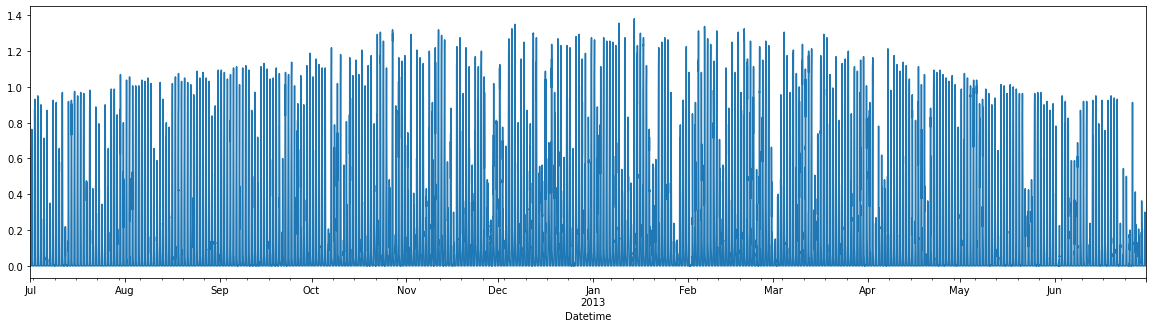

In [ ]:
df_customer_2 = join_dataset(df_clima, df_produccion, 16)
df_customer_2.Produccion.plot(figsize = (20,5))
sts.adfuller(df_customer_2.Produccion)


In [ ]:
result = adfuller(df_customer_2.Produccion)

print("ADF: ", result[0])
print("p-value: ", result[1])
print("nobs: ", result[2])
print("critical values: ", result[4])
print("usedlag: ", result[3])

ADF:  -11.005426652746598
p-value:  6.522410105612038e-20
nobs:  44
critical values:  {'1%': -3.4307242638530675, '5%': -2.861705410152796, '10%': -2.5668580435332715}
usedlag:  17475


In [ ]:
s_dec_additive = seasonal_decompose(df.market_value, model = "additive")
s_dec_additive.plot()
plt.show()

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


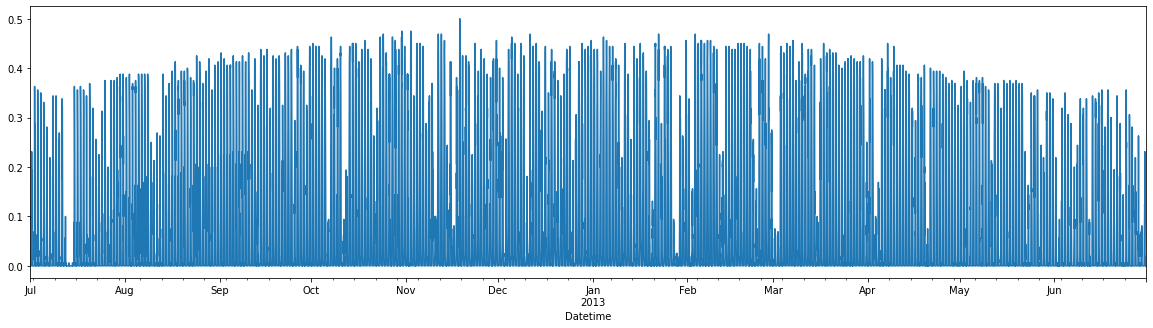

In [ ]:
join_dataset(df_clima, df_produccion, 3).Produccion.plot(figsize = (20,5))